In [1]:
import os
import time
import copy
import random
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torchvision.transforms as transforms
import torchvision.transforms.v2 as T
from torchvision.models import convnext_base
from torchvision.models.vision_transformer import vit_b_16, vit_l_16
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import shutil


In [2]:
import torchvision
print(torchvision.__version__)


0.21.0+cu124


## Project Statement

This notebook demonstrates how to predict whether an image is fake using a custom-trained deep learning model.

The base model is **ConvNeXT**, which I fine-tuned by freezing its core layers and adding custom classification layers for binary prediction (i.e., real vs. fake). The model was trained entirely using **Google Colab**, leveraging GPU acceleration for efficient training.

The trained model showcased here was originally developed for the Kaggle competition:

[Detect AI vs. Human-Generated Images](https://www.kaggle.com/competitions/detect-ai-vs-human-generated-images)


# Download the competition dataset and my trained weight

In [3]:
import kagglehub

# Download dataset (1ogb) from Kaggle
dataset = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")
print("Path to dataset files:", dataset)

# Download my published trained weightig
model_par = kagglehub.model_download("haoyuliao14116/0.77963-best_model_epoch15_f193.90_loss0.1541/pyTorch/default")

print("Path to model files:", model_par)

100%|██████████| 9.76G/9.76G [01:54<00:00, 91.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4



  0%|          | 0.00/336M [00:00<?, ?B/s]
  0%|          | 1.00M/336M [00:00<02:09, 2.71MB/s]
  1%|          | 3.00M/336M [00:00<00:46, 7.48MB/s]
  2%|▏         | 8.00M/336M [00:00<00:17, 19.1MB/s]
  4%|▍         | 14.0M/336M [00:00<00:10, 31.2MB/s]
  5%|▌         | 18.0M/336M [00:00<00:12, 27.0MB/s]
  7%|▋         | 22.0M/336M [00:01<00:12, 27.4MB/s]
  8%|▊         | 26.0M/336M [00:01<00:11, 29.4MB/s]
 10%|▉         | 32.0M/336M [00:01<00:08, 35.9MB/s]
 12%|█▏        | 39.0M/336M [00:01<00:07, 42.7MB/s]
 13%|█▎        | 44.0M/336M [00:01<00:06, 44.2MB/s]
 15%|█▌        | 51.0M/336M [00:01<00:06, 48.3MB/s]
 17%|█▋        | 58.0M/336M [00:01<00:05, 51.6MB/s]
 19%|█▉        | 65.0M/336M [00:01<00:05, 53.2MB/s]
 21%|██        | 71.0M/336M [00:02<00:05, 54.6MB/s]
 23%|██▎       | 77.0M/336M [00:02<00:05, 54.2MB/s]
 25%|██▍       | 84.0M/336M [00:02<00:04, 55.8MB/s]
 27%|██▋       | 90.0M/336M [00:02<00:05, 50.7MB/s]
 28%|██▊       | 95.0M/336M [00:02<00:05, 49.6MB/s]
 30%|███       | 102

Path to model files: /root/.cache/kagglehub/models/haoyuliao14116/0.77963-best_model_epoch15_f193.90_loss0.1541/pyTorch/default/1


# Define the training function

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, save_path='best_model.pth', log_file='training_log.txt'):
    torch.cuda.empty_cache()  # Clear memory
    train_losses, val_losses = [], []
    train_accs, train_f1s, val_accs, val_f1s = [], [], [], []

    best_val_acc = 0.0
    best_val_f1 = 0.0
    best_val_loss = float('inf')

    for epoch in range(0, num_epochs+0):
        start_time = time.time()
        print(f"Starting Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        train_all_preds, train_all_labels = [], []
        for images, labels, _ in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            train_all_preds.append(predicted.cpu().view(-1))  # Ensure shape is (N,)
            train_all_labels.append(labels.cpu().view(-1))    # Ensure shape is (N,)

        # Compute F1-Score after epoch
        if train_all_preds:
            train_all_preds = torch.cat(train_all_preds).numpy()
            train_all_labels = torch.cat(train_all_labels).numpy()
        else:
            train_all_preds = np.array([])
            train_all_labels = np.array([])

        train_f1 = f1_score(train_all_labels, train_all_preds, average='binary') * 100

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        val_all_preds, val_all_labels = [], []

        with torch.no_grad():
            for images, labels, _ in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                val_all_preds.append(predicted.cpu().view(-1))
                val_all_labels.append(labels.cpu().view(-1))

        if val_all_preds:
            val_all_preds = torch.cat(val_all_preds).numpy()
            val_all_labels = torch.cat(val_all_labels).numpy()
        else:
            val_all_preds = np.array([])
            val_all_labels = np.array([])

        val_f1 = f1_score(val_all_labels, val_all_preds, average='binary') * 100

        val_loss /= len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_time = end_time - start_time
        log_message = f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train F1: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.2f}% | Time: {epoch_time:.2f} sec"
        print(log_message)
        with open(log_file, 'a') as f:
            f.write(log_message + '\n')

        # Save best model
        if val_f1 > best_val_f1 or (val_f1 == best_val_f1 and val_loss < best_val_loss):
            best_val_f1, best_val_loss = val_f1, val_loss
            model_filename = f"best_model_epoch{epoch+1}_f1{best_val_f1:.2f}_loss{best_val_loss:.4f}.pth"
            torch.save(model.state_dict(), model_filename)
            log_message = f"Best model saved with Val F1: {best_val_f1:.2f}% and Val Loss:{best_val_loss}"
            print(log_message)
            with open(log_file, 'a') as f:
                f.write(log_message + '\n')
        else:  #Save model for each epoch
            model_filename = f"best_model_epoch{epoch+1}_f1{val_f1:.2f}_loss{val_loss:.4f}.pth"
            torch.save(model.state_dict(), model_filename)
            log_message = f"Model saved with Val F1: {val_f1:.2f}% and Val Loss:{val_loss}"
            print(log_message)
            with open(log_file, 'a') as f:
                f.write(log_message + '\n')

        submission(model, epoch=epoch+1)



        # Step the Learning Rate Scheduler AFTER Validation
        scheduler.step(val_loss)
        torch.cuda.empty_cache()  # Clear unused memory

    # Plot loss and accuracy
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(range(1, num_epochs+1), train_accs, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(range(1, num_epochs+1), train_f1s, label='Train F1')
    plt.plot(range(1, num_epochs+1), val_f1s, label='Validation F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 (%)')
    plt.title('Training and Validation F1')
    plt.legend()

    plt.tight_layout()

    plt.savefig('training_metrics.png')  # Save single plot instead of multiple
    plt.show()



# Define transform

In [8]:
#Define transformations for training dataset
class TrainTransform(Dataset):
    def __init__(self, dataset): #pd.read_csv(excel_file, header=0) #[:100] #for tial if codes can run

        self.data = dataset
        self.image_paths = self.data.iloc[:, 1].values  # Column 1: Image paths
        self.labels = self.data.iloc[:, 2].values  # Column 2: Labels (0 or 1)

        self.train_transform_fake = T.Compose([
            T.Resize(300),  # Resize to match ConvNeXt preprocessing
            #T.RandomResizedCrop(224, scale=(0.8, 1.0)),
            T.RandomRotation(degrees=30),
            T.CenterCrop(224),
            T.ColorJitter(
                    brightness=(0.2, 1.2),  # Adjust brightness between 20% and 120%
                    contrast=(0.1, 1.5),    # Adjust contrast between 10% and 150%
                    saturation=(0.1, 1.2),  # Adjust saturation between 10% and 120%
                    hue=(-0.2, 0.2)         # Adjust hue within ±20% of 180° color spectrum
                ),
            T.RandomAutocontrast(p=0.5),  # Randomly apply autocontrast
            T.GaussianBlur(kernel_size=5, sigma=(0.3, 2.0)),
            T.ToTensor(),
            T.GaussianNoise(mean=0.0, sigma=0.05, clip=True),  # Add Gaussian noise
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.train_transform_real = T.Compose([
            T.Resize(232),  # Resize to 232 as per ConvNeXt documentation
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = "/root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4/"+self.image_paths[idx]
        label = self.labels[idx]
        ImageRGB = Image.open(image_path).convert("RGB")
        imageTran = self.train_transform_fake(ImageRGB)

        return imageTran, label, image_path

#Define transformations for validtion and testing dataset
class ValiTestTransform(Dataset):
    def __init__(self, dataset): #pd.read_csv(excel_file, header=0) #[:100] #for tial if codes can run

        self.data = dataset
        self.image_paths = self.data.iloc[:, 1].values  # Column 1: Image paths
        self.labels = self.data.iloc[:, 2].values  # Column 2: Labels (0 or 1)

        self.train_transform = T.Compose([
            T.Resize(232),  # Resize to 232 as per ConvNeXt documentation
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = "/root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4/"+self.image_paths[idx]
        label = self.labels[idx]
        ImageRGB = Image.open(image_path).convert("RGB")
        imageTran = self.train_transform(ImageRGB)


        return imageTran, label, image_path

#Define transformations for unknonwn dataset
class UnknownTransform(Dataset):
    def __init__(self, dataset): #pd.read_csv(excel_file, header=0) #[:100] #for tial if codes can run

        self.data = dataset
        self.image_paths = self.data.iloc[:, 0].values


        self.unknown_transform = T.Compose([
            T.Resize(232),  # Resize to 232 as per ConvNeXt documentation
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = "/root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4/"+self.image_paths[idx]
        ImageRGB = Image.open(image_path).convert("RGB")
        imageTran = self.unknown_transform(ImageRGB)


        return imageTran, image_path

def get_class_distribution(data_loader):
    """
    Counts the number of occurrences of each class label in a DataLoader.

    Args:
        data_loader (DataLoader): The PyTorch DataLoader (e.g., test_loader).

    Returns:
        dict: A dictionary where keys are class labels and values are their counts.
    """
    class_counts = Counter()

    # Loop through data_loader and count labels
    for _, labels, _ in data_loader:
        class_counts.update(labels.cpu().numpy())  # Convert tensor to NumPy and count

        # Print class distribution
    for class_label, count in sorted(class_counts.items()):
        print(f"Class {class_label}: {count} samples")


def submission(model, epoch=14, saveImg = False): #Submission format for Kaggle
    model.eval()
    unknown_dataset = pd.read_csv("/root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4/test.csv", header=0)
    unknown_dataset = UnknownTransform(unknown_dataset)
    if saveImg:
        unknown_loader = DataLoader(unknown_dataset, batch_size=1, shuffle=False, num_workers=4)
    else:
        unknown_loader = DataLoader(unknown_dataset, batch_size=32, shuffle=False, num_workers=4)

    unknown_logits = []
    unknown_pred = []
    os.makedirs('testPred', exist_ok=True)
    with torch.no_grad():
        n = 1
        for images, image_path in tqdm(unknown_loader, desc="Unknown Predictions"):
            images = images.to(device)
            outputs = model(images)
            unknown_logits.extend(outputs.cpu().numpy())
            preds = outputs.argmax(dim=1)
            predslabel = preds.cpu().numpy()
            unknown_pred.extend(predslabel)
            #save predict imgs:
            if saveImg:
                plt.figure(figsize=(4,6))
                image_path = image_path[0]
                img = Image.open(image_path)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Prediction: {predslabel[0]}")
                plt.savefig(f"testPred/{n}_pred_{predslabel[0]}_{os.path.basename(image_path)}", bbox_inches='tight')
                plt.close()
                n+=1


    shutil.make_archive("testPred", 'zip', "testPred")
    print("Zipped testPred folder successfully!")

    unknown_excel = pd.read_csv("/root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4/test.csv", header=0)

    unknown_logits_df = pd.DataFrame(unknown_logits, columns=['logit_cla_0', 'logit_cla_1'])
    unknown_logits_df['id'] = unknown_excel['id'].values

    unknown_excel['label'] = unknown_pred
    class_counts = unknown_excel['label'].value_counts()
    print(class_counts)
    unknown_excel.to_csv(f"{epoch}_{class_counts[1]}_unknown.csv", index=False)
    unknown_logits_df.to_csv(f'{epoch}_{class_counts[1]}_unknown_logits.csv', index=False)
    print("Predictions saved to unknown.csv")
    #Actual 1s (TP) = 2767.
    #Actual 0s (TN) = 2773.

# Split Dataset

In [38]:
full_dataset = pd.read_csv("/root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4/train.csv", header=0)

# Ensure the dataset has at least some samples
dataset_size = len(full_dataset)

# Define split sizes
train_ratio = 0.95
val_ratio = 0.03
test_ratio = 1 - (train_ratio + val_ratio)  # Ensures all data is used

train_dataset, temp_data = train_test_split(full_dataset, test_size=(1 - train_ratio), random_state=42, shuffle=False)
val_dataset, test_dataset = train_test_split(temp_data, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42, shuffle=False)


In [39]:
train_dataset = TrainTransform(train_dataset)
val_dataset = ValiTestTransform(val_dataset)
test_dataset = ValiTestTransform(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Training Set Size: {len(train_dataset)}")
print(f"Validation Set Size: {len(val_dataset)}")
print(f"Testing Set Size: {len(test_dataset)}")
get_class_distribution(test_loader)

Training Set Size: 75952
Validation Set Size: 2398
Testing Set Size: 1600


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Class 0: 800 samples
Class 1: 800 samples


tensor(1)


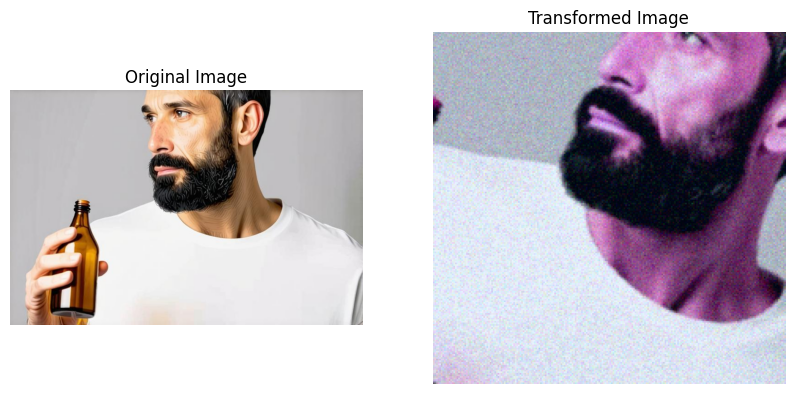

In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Plot the original and transform images.
for imageTran, label, image_path in train_loader:
    print(label[0])
    # Load the original image using PIL
    original_image = Image.open(image_path[0])  # image_path[0] because image_path is a batch

    # Convert the transformed image from (C, H, W) to (H, W, C)
    transformed_image = imageTran[0].permute(1, 2, 0).numpy()

    # Clip the transformed image to ensure pixel values are in range [0, 1]
    transformed_image = (transformed_image - transformed_image.min()) / (transformed_image.max() - transformed_image.min())

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display the transformed image
    axes[1].imshow(transformed_image)
    axes[1].set_title("Transformed Image")
    axes[1].axis('off')

    plt.show()
    break


## Load the trained model

In [19]:
# Load pretrained ConvNeXt Base model
model = convnext_base(weights="DEFAULT")

# Freeze all layers initially
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze the last two stages
for param in model.features[-2:].parameters():
    param.requires_grad = True

# Replace the classifier head with a custom one
model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
    nn.Flatten(),                  # Flatten the tensor
    nn.BatchNorm1d(1024),          # Add BatchNorm here
    nn.Linear(1024, 512),          # First fully connected layer
    nn.ReLU(),                     # Activation function
    nn.Dropout(0.4),               # Dropout for regularization
    nn.Linear(512, 2)              # Output layer (binary classification)
)

# Move the model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

# Define loss function, optimizer, and learning rate scheduler
optimizer = torch.optim.AdamW([
    {'params': model.features[-2:].parameters(), 'lr': 1e-5},  # Lower LR for backbone
    {'params': model.classifier.parameters(), 'lr': 1e-4}      # Higher LR for classifier
])

criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

Starting Epoch 1/13


Validation Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 1: 100%|██████████| 75/75 [00:28<00:00,  2.67it/s]


Epoch 1/13 | Train Loss: 0.4360 | Train F1: 78.97% | Val Loss: 0.2990 | Val F1: 88.11% | Time: 2472.20 sec


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Best model saved with Val F1: 88.11% and Val Loss:0.2989990524450938


Unknown Predictions: 100%|██████████| 174/174 [02:17<00:00,  1.26it/s]


Zipped testPred folder successfully!
label
1    2847
0    2693
Name: count, dtype: int64
Predictions saved to unknown.csv
Starting Epoch 2/13


Training Epoch 2:   0%|          | 0/2374 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if ne

Epoch 2/13 | Train Loss: 0.3380 | Train F1: 84.74% | Val Loss: 0.2803 | Val F1: 88.76% | Time: 2462.93 sec


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Best model saved with Val F1: 88.76% and Val Loss:0.2802514279882113


Unknown Predictions: 100%|██████████| 174/174 [02:19<00:00,  1.25it/s]


Zipped testPred folder successfully!
label
1    2839
0    2701
Name: count, dtype: int64
Predictions saved to unknown.csv
Starting Epoch 3/13


Training Epoch 3:   0%|          | 0/2374 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if ne

Epoch 3/13 | Train Loss: 0.3079 | Train F1: 86.46% | Val Loss: 0.2422 | Val F1: 90.37% | Time: 2468.70 sec


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Best model saved with Val F1: 90.37% and Val Loss:0.24216688960790633


Unknown Predictions: 100%|██████████| 174/174 [02:20<00:00,  1.24it/s]


Zipped testPred folder successfully!
label
0    2843
1    2697
Name: count, dtype: int64
Predictions saved to unknown.csv
Starting Epoch 4/13


Training Epoch 4:   0%|          | 0/2374 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if ne

Epoch 4/13 | Train Loss: 0.2880 | Train F1: 87.33% | Val Loss: 0.1886 | Val F1: 92.78% | Time: 2474.41 sec


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Best model saved with Val F1: 92.78% and Val Loss:0.1886343971391519


Unknown Predictions: 100%|██████████| 174/174 [02:20<00:00,  1.23it/s]


Zipped testPred folder successfully!
label
0    3168
1    2372
Name: count, dtype: int64
Predictions saved to unknown.csv
Starting Epoch 5/13


Training Epoch 5:   0%|          | 0/2374 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 5:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if ne

Epoch 5/13 | Train Loss: 0.2714 | Train F1: 88.10% | Val Loss: 0.2168 | Val F1: 91.42% | Time: 2469.95 sec


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model saved with Val F1: 91.42% and Val Loss:0.21675594101349513


Unknown Predictions: 100%|██████████| 174/174 [02:19<00:00,  1.25it/s]


Zipped testPred folder successfully!
label
0    2922
1    2618
Name: count, dtype: int64
Predictions saved to unknown.csv
Starting Epoch 6/13


Training Epoch 6:   0%|          | 0/2374 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 6:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if ne

Epoch 6/13 | Train Loss: 0.2608 | Train F1: 88.64% | Val Loss: 0.2427 | Val F1: 90.40% | Time: 2468.82 sec


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model saved with Val F1: 90.40% and Val Loss:0.24265209982792538


Unknown Predictions: 100%|██████████| 174/174 [02:20<00:00,  1.24it/s]


Zipped testPred folder successfully!
label
1    2857
0    2683
Name: count, dtype: int64
Predictions saved to unknown.csv
Starting Epoch 7/13


Training Epoch 7:   0%|          | 0/2374 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 7:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if ne

Epoch 7/13 | Train Loss: 0.2481 | Train F1: 89.23% | Val Loss: 0.2220 | Val F1: 91.22% | Time: 2465.90 sec


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model saved with Val F1: 91.22% and Val Loss:0.2219877079129219


Unknown Predictions: 100%|██████████| 174/174 [02:19<00:00,  1.25it/s]


Zipped testPred folder successfully!
label
0    2825
1    2715
Name: count, dtype: int64
Predictions saved to unknown.csv
Starting Epoch 8/13


Training Epoch 8:   0%|          | 0/2374 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 8:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if ne

Epoch 8/13 | Train Loss: 0.2375 | Train F1: 89.60% | Val Loss: 0.2050 | Val F1: 92.19% | Time: 2463.06 sec


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model saved with Val F1: 92.19% and Val Loss:0.2050400507946809


Unknown Predictions: 100%|██████████| 174/174 [02:19<00:00,  1.25it/s]


Zipped testPred folder successfully!
label
0    2875
1    2665
Name: count, dtype: int64
Predictions saved to unknown.csv
Starting Epoch 9/13


Training Epoch 9:   0%|          | 0/2374 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 9:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if ne

Epoch 9/13 | Train Loss: 0.2321 | Train F1: 90.01% | Val Loss: 0.2304 | Val F1: 91.60% | Time: 2465.52 sec


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model saved with Val F1: 91.60% and Val Loss:0.23037075191736223


Unknown Predictions: 100%|██████████| 174/174 [02:18<00:00,  1.25it/s]


Zipped testPred folder successfully!
label
0    2780
1    2760
Name: count, dtype: int64
Predictions saved to unknown.csv
Starting Epoch 10/13


Training Epoch 10:   0%|          | 0/2374 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 10:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

Epoch 10/13 | Train Loss: 0.2260 | Train F1: 90.32% | Val Loss: 0.2275 | Val F1: 91.50% | Time: 2466.68 sec


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model saved with Val F1: 91.50% and Val Loss:0.22754945869247117


Unknown Predictions: 100%|██████████| 174/174 [02:19<00:00,  1.25it/s]


Zipped testPred folder successfully!
label
1    2813
0    2727
Name: count, dtype: int64
Predictions saved to unknown.csv
Starting Epoch 11/13


Training Epoch 11:   0%|          | 0/2374 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 11:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

Epoch 11/13 | Train Loss: 0.2239 | Train F1: 90.33% | Val Loss: 0.1997 | Val F1: 92.39% | Time: 2479.48 sec


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model saved with Val F1: 92.39% and Val Loss:0.19966976270079612


Unknown Predictions: 100%|██████████| 174/174 [02:20<00:00,  1.24it/s]


Zipped testPred folder successfully!
label
0    2855
1    2685
Name: count, dtype: int64
Predictions saved to unknown.csv
Starting Epoch 12/13


Training Epoch 12:   0%|          | 0/2374 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 12:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

Epoch 12/13 | Train Loss: 0.2187 | Train F1: 90.69% | Val Loss: 0.1926 | Val F1: 92.45% | Time: 2472.94 sec


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model saved with Val F1: 92.45% and Val Loss:0.19258583312233288


Unknown Predictions: 100%|██████████| 174/174 [02:21<00:00,  1.23it/s]


Zipped testPred folder successfully!
label
0    2902
1    2638
Name: count, dtype: int64
Predictions saved to unknown.csv
Starting Epoch 13/13


Training Epoch 13:   0%|          | 0/2374 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation Epoch 13:   0%|          | 0/75 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if 

Epoch 13/13 | Train Loss: 0.2153 | Train F1: 90.88% | Val Loss: 0.1696 | Val F1: 93.80% | Time: 2468.37 sec


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Best model saved with Val F1: 93.80% and Val Loss:0.16958090516428154


Unknown Predictions: 100%|██████████| 174/174 [02:17<00:00,  1.26it/s]


Zipped testPred folder successfully!
label
0    3045
1    2495
Name: count, dtype: int64
Predictions saved to unknown.csv


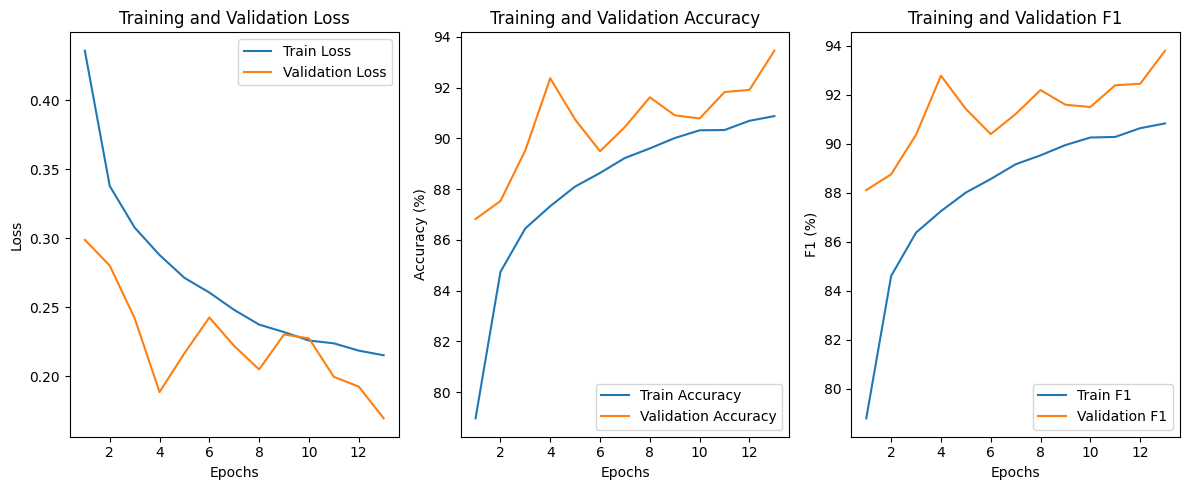

In [ ]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=13)

In [16]:
import shutil

def submission(model, epoch=14, saveImg = False):
    model.eval()
    unknown_dataset = pd.read_csv("/root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4/test.csv", header=0)
    unknown_dataset = UnknownTransform(unknown_dataset)
    if saveImg:
        unknown_loader = DataLoader(unknown_dataset, batch_size=1, shuffle=False, num_workers=4)
    else:
        unknown_loader = DataLoader(unknown_dataset, batch_size=32, shuffle=False, num_workers=4)

    unknown_logits = []
    unknown_pred = []
    os.makedirs('test3Pred', exist_ok=True)
    with torch.no_grad():
        n = 1
        for images, image_path in tqdm(unknown_loader, desc="Unknown Predictions"):
            images = images.to(device)
            outputs = model(images)
            unknown_logits.extend(outputs.cpu().numpy())
            preds = outputs.argmax(dim=1)
            predslabel = preds.cpu().numpy()
            unknown_pred.extend(predslabel)
            #save predict imgs:
            if saveImg:
                image_path = image_path[0]
                source_path = image_path
                destination_path = f"test3Pred/{n}_pred_{predslabel[0]}_{os.path.basename(image_path)}"
                shutil.copy2(source_path, destination_path)  # copy2 preserves metadata

                n+=1


    shutil.make_archive("test3Pred", 'zip', "test3Pred")
    print("Zipped testPred folder successfully!")

    unknown_excel = pd.read_csv("/root/.cache/kagglehub/datasets/alessandrasala79/ai-vs-human-generated-dataset/versions/4/test.csv", header=0)

    unknown_logits_df = pd.DataFrame(unknown_logits, columns=['logit_cla_0', 'logit_cla_1'])
    unknown_logits_df['id'] = unknown_excel['id'].values

    unknown_excel['label'] = unknown_pred
    class_counts = unknown_excel['label'].value_counts()
    print(class_counts)
    unknown_excel.to_csv(f"{epoch}_{class_counts[1]}_unknown.csv", index=False)
    unknown_logits_df.to_csv(f'{epoch}_{class_counts[1]}_unknown_logits.csv', index=False)
    print("Predictions saved to unknown.csv")

In [17]:
submission(model, epoch=13, saveImg = False)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Unknown Predictions: 100%|██████████| 174/174 [02:07<00:00,  1.36it/s]


Zipped testPred folder successfully!
label
0    2791
1    2749
Name: count, dtype: int64
Predictions saved to unknown.csv


# Load the trained model parameters (I trained for the competition)

In [40]:
# Load pretrained ConvNeXt Base model
model = convnext_base(weights="DEFAULT")

# Freeze all layers initially
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze the last two stages
for param in model.features[-2:].parameters():
    param.requires_grad = True

# Replace the classifier head with a custom one
model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
    nn.Flatten(),                  # Flatten the tensor
    nn.BatchNorm1d(1024),          # Add BatchNorm here
    nn.Linear(1024, 512),          # First fully connected layer
    nn.ReLU(),                     # Activation function
    nn.Dropout(0.4),               # Dropout for regularization
    nn.Linear(512, 2)              # Output layer (binary classification)
)

# Move the model to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load the trained model parameters (I trained for the competition)
load_path = "/root/.cache/kagglehub/models/haoyuliao14116/0.77963-best_model_epoch15_f193.90_loss0.1541/pyTorch/default/1/0.77963-best_model_epoch15_f193.90_loss0.1541.pth"
model.load_state_dict(torch.load(load_path, map_location=device))
model = model.to(device)

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels, _ in tqdm(test_loader, desc="Test Predictions"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average='binary') * 100
    recall = recall_score(all_labels, all_preds, average='binary') * 100
    f1 = f1_score(all_labels, all_preds, average='binary') * 100

    print(f"Test Accuracy: {acc:.2f}%")
    print(f"Test Precision: {precision:.2f}%")
    print(f"Test Recall: {recall:.2f}%")
    print(f"Test F1 Score: {f1:.2f}%")

evaluate_model(model, test_loader)



Test Predictions: 100%|██████████| 50/50 [00:20<00:00,  2.45it/s]

Test Accuracy: 93.50%
Test Precision: 88.84%
Test Recall: 99.50%
Test F1 Score: 93.87%


# Predict fake and real images

In [42]:
all_preds = []
all_labels = []
shown_images = 0
max_images_to_show = 10

label_map = {0: "Real", 1: "Fake"}

with torch.no_grad():
    for images, labels, image_paths in tqdm(test_loader, desc="Test Predictions"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        batch_size = images.size(0)
        for i in range(batch_size):
            if shown_images >= max_images_to_show:
                break

            # Load original image
            original_image = Image.open(image_paths[i])

            # Show image with prediction and label using label_map
            plt.figure(figsize=(5, 5))
            plt.imshow(original_image)
            plt.title(f"Predicted: {label_map[predicted[i].item()]} | Label: {label_map[labels[i].item()]}")
            plt.axis('off')
            plt.show()

            shown_images += 1

        if shown_images >= max_images_to_show:
            break


Output hidden; open in https://colab.research.google.com to view.